# MGIMO intensive

## RAG demo

### 1. Overview

In this assignment, you will gain hands-on experience in implementing a Retrieval-Augmented Generation (RAG) pipeline. This technique combines the power of retrieval systems and language models to generate contextually accurate responses by searching through external documents. RAG is particularly useful in business applications for improving customer support, summarization, and information retrieval tasks. You will use **LangChain**, a popular framework for building applications with language models, and **YandexGPT**, a large language model (LLM) for generating answers to both manually created and automatically generated questions.

### 2. Understanding Retrieval-Augmented Generation (RAG)

**Retrieval-Augmented Generation (RAG)** is an approach that combines document retrieval systems with generative models (LLMs). The idea is to first retrieve relevant documents based on a query and then use a generative model to produce responses grounded in the retrieved content. In this homework, you'll be building your own RAG pipeline using **LangChain** and **YandexGPT**.

Key steps:

1. **Preprocessing**: Split documents into small chunks so that the length of each chunk does not exceed the length of the LLM context. It is recommended to split each document into chunks of 1500-2000 characters with an overlap of 200-300 characters.
2. **Embeddings loading**: Run all the chunks through a LLM to get chunk embeddings, and then insert the embeddings into a vector database to form a search index.

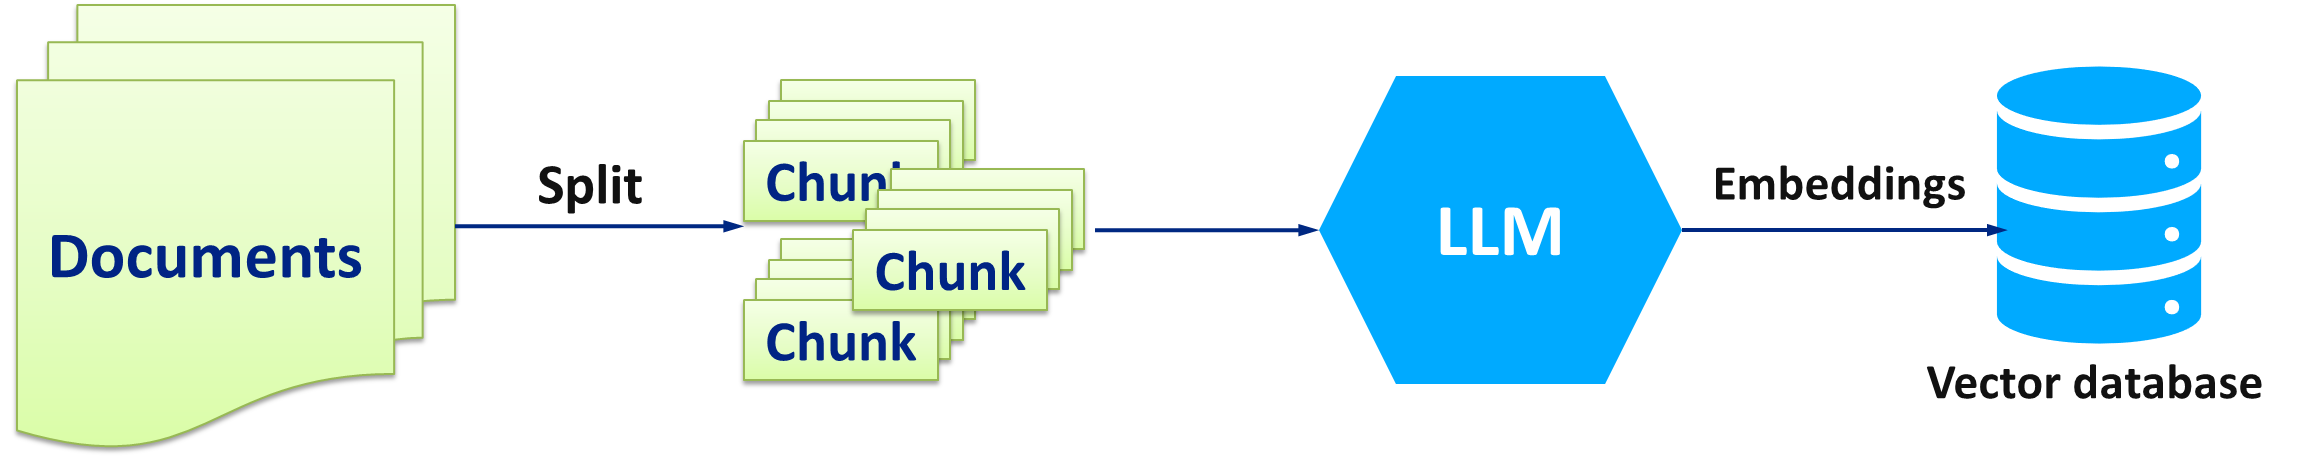

3. **Retrieval**: Run a user query (prompt) though a LLM and select chunks that are most relevant to a user’s query from the vector database.

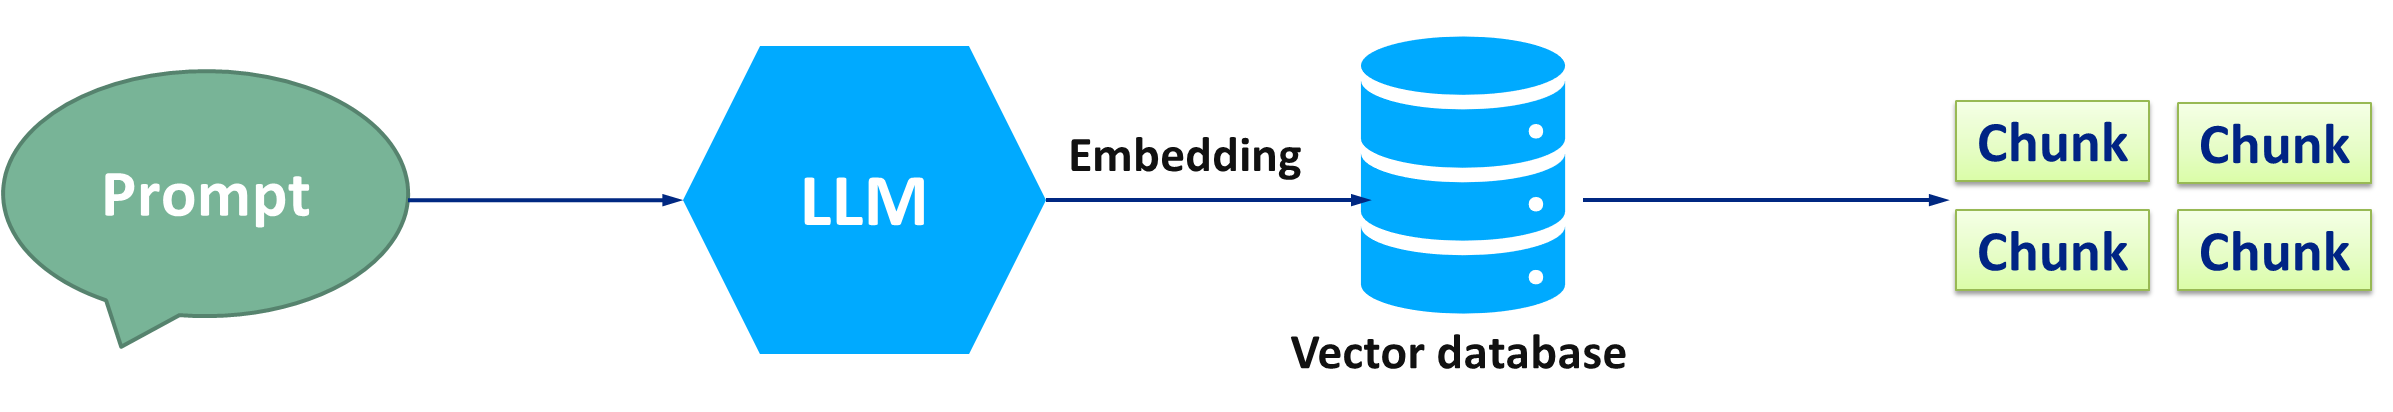

4. **Generation**: The LLM generates responses based on both the query and the retrieved chunks, producing a more contextually relevant answer.

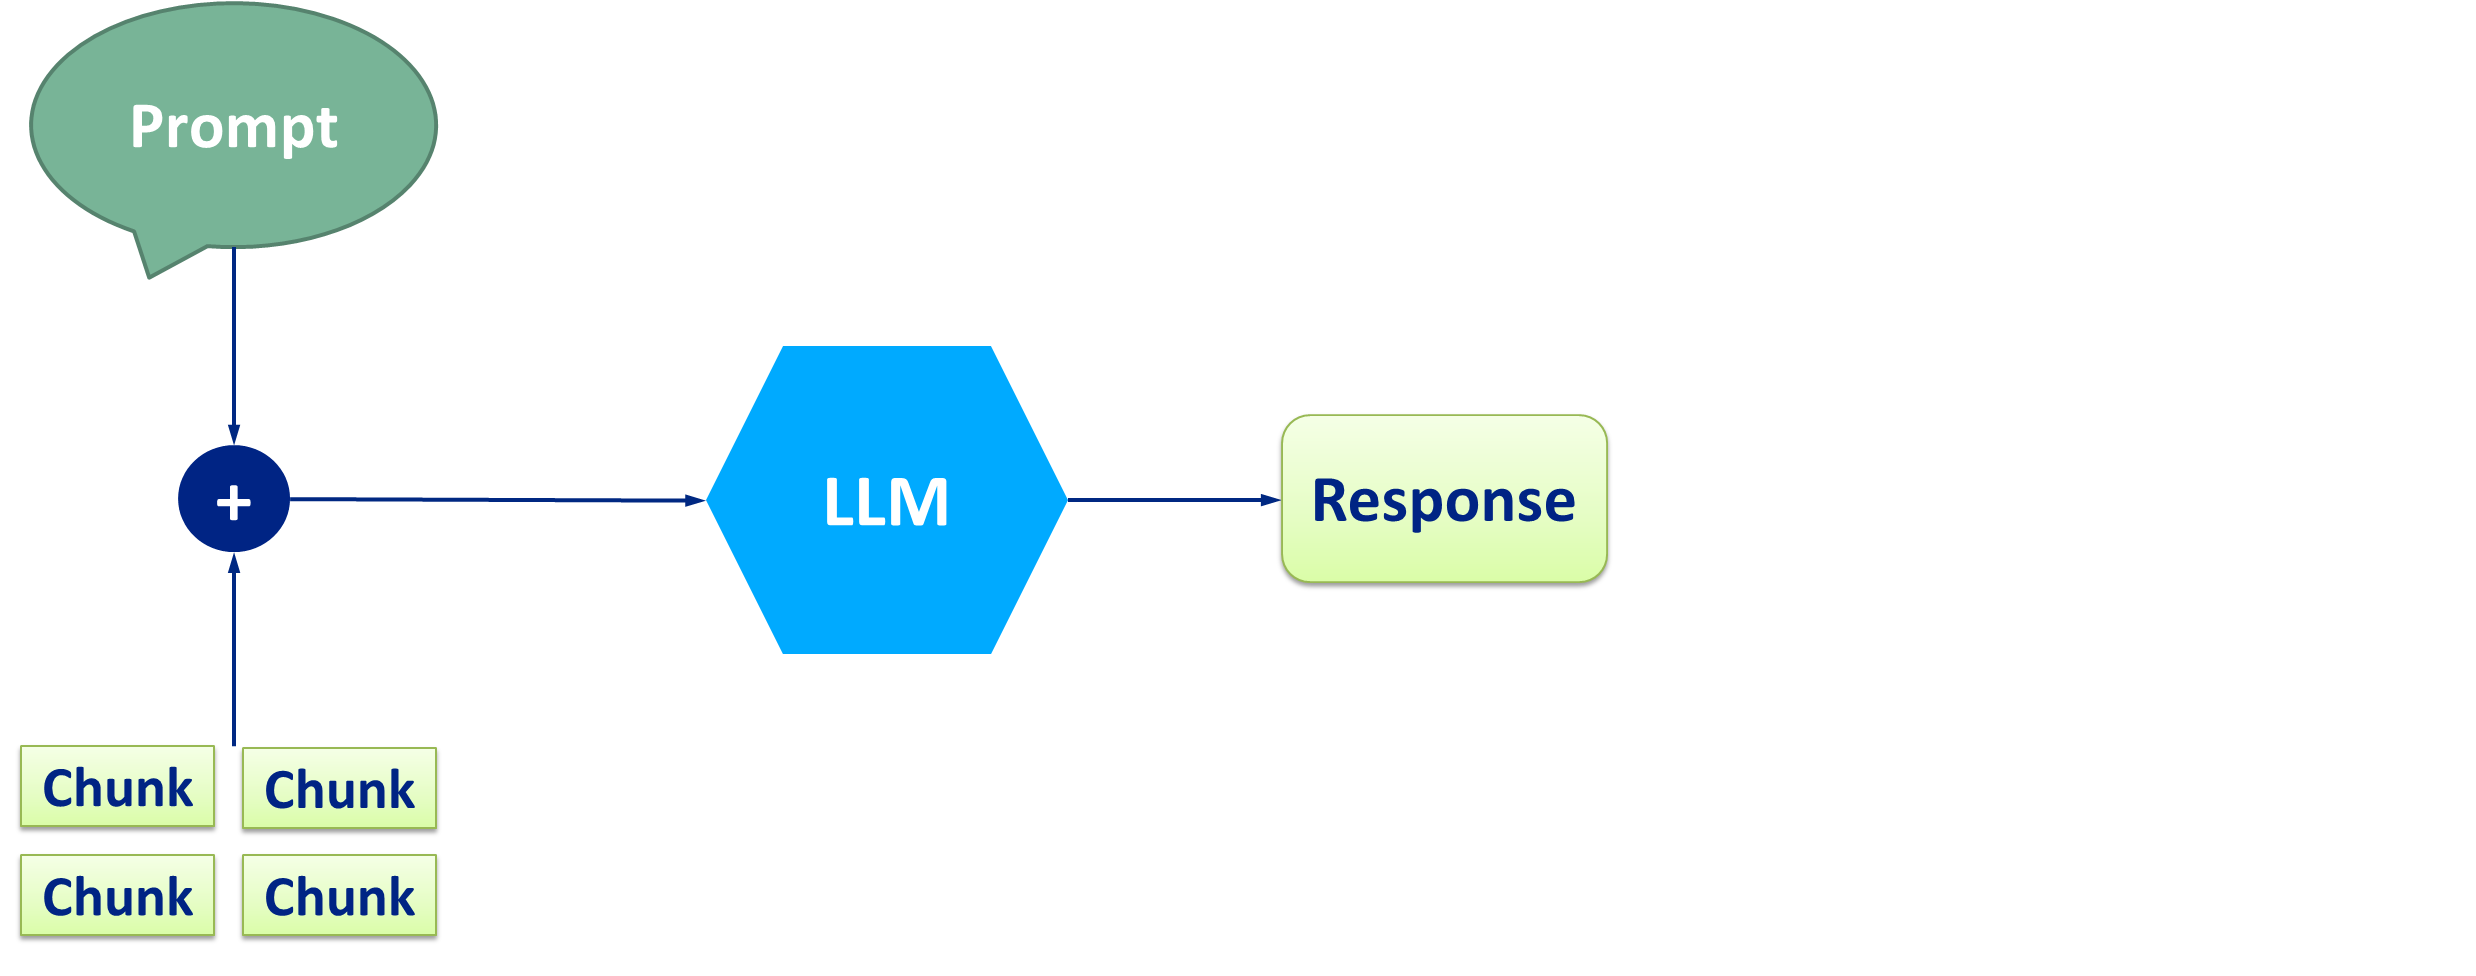

### 3. Introduction to LangChain

#### 3.1. About

**LangChain** is a framework that helps developers build applications using LLMs. It supports chaining together various components such as retrieval mechanisms, prompt templates, and LLM queries into a coherent pipeline. You will use LangChain to integrate the LLM and document retrieval system into a single workflow. Langchain consists of several components:

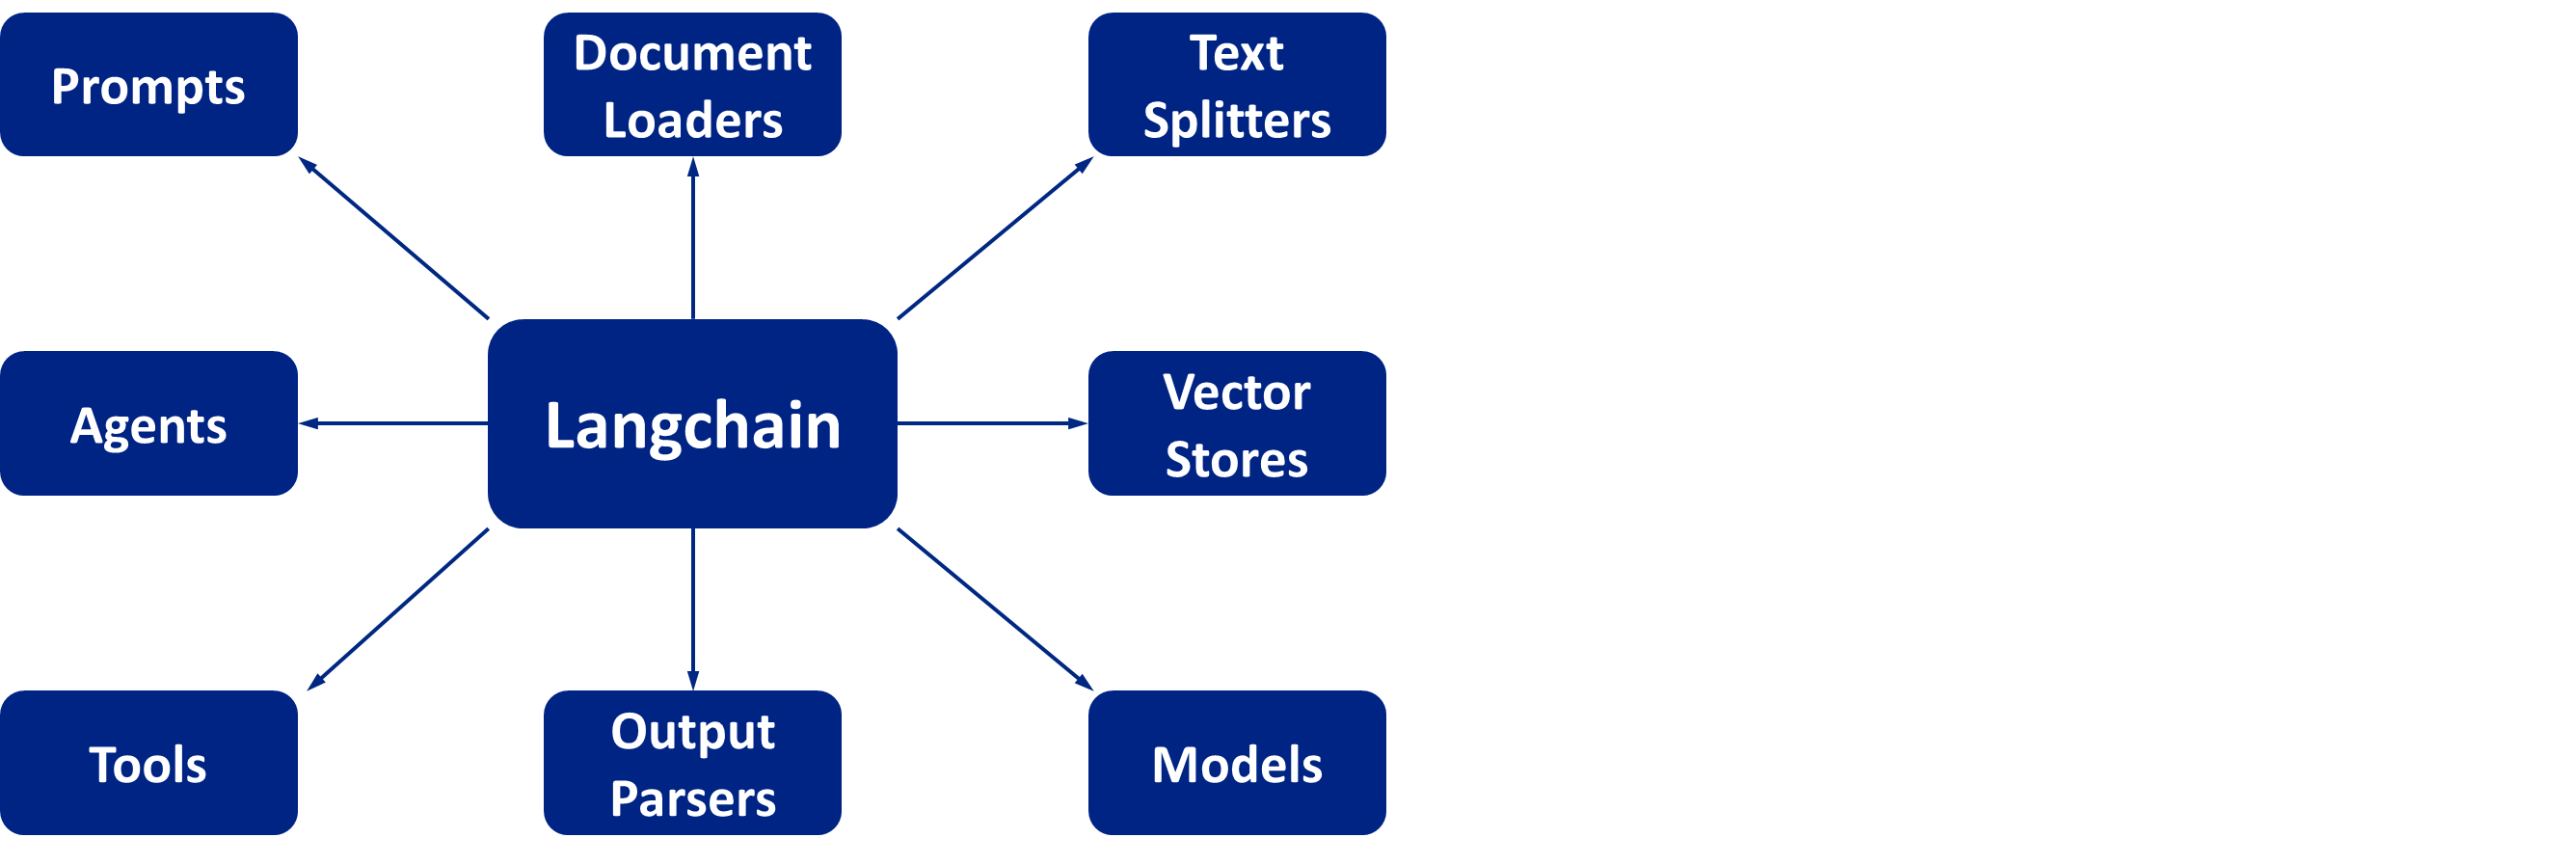

All components can be combined into **chains**. A **chain** is a sequence of component calls.

The **chain** itself is also a component, so simple chains can be used to form more complex сhains.

Here are some useful links to documentation where you can find hints regarding the implementation of the pipelines:

* <a href="https://python.langchain.com/v0.2/docs/tutorials/llm_chain/">Simple LLM</a>
* <a href="https://python.langchain.com/v0.2/docs/tutorials/retrievers/">Vector Stores and Retrievers</a>
* <a href="https://python.langchain.com/v0.2/docs/tutorials/rag/">RAG example</a>
* <a href="https://python.langchain.com/v0.2/docs/tutorials/">List of tutorials</a>
* <a href="https://python.langchain.com/v0.2/docs/introduction/">Langchain Into</a>
* <a href="https://python.langchain.com/docs/integrations/text_embedding/yandex/">YandexGPT Embeddings</a>
* <a href="https://python.langchain.com/docs/integrations/llms/yandex/">YandexGPT LLM</a>

### 4. RAG implementation

#### 4.1. Libraries for the project

In [ ]:
!pip install langchain-community==0.3.27 chromadb langchain-chroma==0.1.4 \
    yandex-cloud-ml-sdk unstructured

In [ ]:
import json
import urllib.request
from pathlib import Path
from langchain.document_loaders import DirectoryLoader, PyMuPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain_community.embeddings.yandex import YandexGPTEmbeddings
from langchain_community.chat_models import ChatYandexGPT
from langchain_community.llms import YandexGPT
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

#### 4.2. Upload and process documents

In [ ]:
DOCS_PATH = "/home/jovyan/__DATA/mgimo_intensive/leo/txt"

In [ ]:
loader = DirectoryLoader(DOCS_PATH)
docs = loader.load()
print("Documents loaded:", len(docs))

In [ ]:
print("Document content (first 100 symbols):", docs[0].page_content[:100])

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # tune for better RAG performance
    chunk_overlap=200  # tune for better RAG performance
)
splits = text_splitter.split_documents(docs)

In [ ]:
print("One split content:", splits[0].page_content)

In [ ]:
splits[0].metadata

In [ ]:
len(splits)

#### 4.3. Put data to vectorstore

In [ ]:
def json_data(file_path):
    """Load and return JSON data from a file.
    
    Args:
        file_path (str): Path to the JSON file.
    
    Returns:
        dict or list: Parsed JSON data.
    """
    with open(file_path) as file:
        data = json.load(file)
    return data

In [ ]:
creds = json_data("/home/jovyan/__DATA/mgimo_intensive/.accessyagpt")
API_KEY = creds["api_key"]
FOLDER_ID = creds["folder_id"]

In [ ]:
%%time

vectorstore = Chroma.from_documents(
    documents=splits, 
    embedding=YandexGPTEmbeddings(
        api_key=API_KEY, 
        folder_id=FOLDER_ID,
        sleep_interval=.1
    )
)

#### 4.4. Get the chain

In [ ]:
retriever = vectorstore.as_retriever(
    search_type="similarity", 
    search_kwargs={"k": 3}  # how many splits to extract
)

In [ ]:
template = (
    "Используй приведенный контекст, чтобы ответить на вопрос в конце. "
    "Если ты не знаешь ответа, так и скажи, не пытайся придумывать. "
    "Ответ должен быть максимально кратким (не больше трех предложений). "
    "В конце ответа всегда добавляй: \"Спасибо за вопрос!\". \n"
    "Контекст: {context}\n"
    "Вопрос: {question}\n"
    "Ответ: "
)

prompt = PromptTemplate.from_template(template)

In [ ]:
llm = YandexGPT(
    name="yandexgpt",
    api_key=API_KEY, 
    folder_id=FOLDER_ID
)

In [ ]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [ ]:
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

#### 4.5. Test the chain

In [ ]:
def print_answer(question, answer):
    print("=" * 60)
    print(f"❓ ВОПРОС: {question}")
    print("-" * 60)
    print(f"💡 ОТВЕТ: {answer}")
    print("=" * 60)
    print("✅ Готово!")

In [ ]:
question = "Как называется заповедник?"

answer = rag_chain.invoke(question)
print_answer(question, answer)

In [ ]:
question = "Какой период охватывают документы?"

answer = rag_chain.invoke(question)
print_answer(question, answer)